In [22]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from IPython.display import Image
from torchvision.utils import save_image
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

# Loading Fashion Mnist

In [2]:

# Step 1: Load fashion mnist
fmnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [3]:
### Supposedly import pytorch in jupyter notebook breaks matplotlib for some reason
# this is a temporary fix
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [4]:
img, label = fmnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [5]:
# Use if the vals are 0-1
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


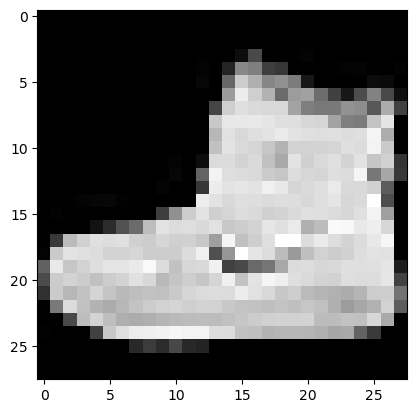

In [6]:

%matplotlib inline

# show the image
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [7]:

batch_size = 100
data_loader = DataLoader(fmnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([1, 2, 4, 1, 2, 9, 4, 0, 2, 0, 2, 2, 3, 4, 1, 0, 7, 7, 1, 5, 9, 4, 4, 4,
        3, 6, 5, 0, 0, 2, 6, 4, 4, 8, 8, 9, 6, 2, 9, 2, 8, 1, 7, 8, 9, 4, 9, 6,
        6, 1, 5, 8, 5, 6, 2, 5, 1, 5, 7, 3, 5, 8, 1, 2, 9, 1, 3, 5, 0, 1, 5, 7,
        6, 9, 0, 7, 3, 9, 8, 9, 1, 0, 3, 8, 4, 0, 3, 7, 8, 9, 7, 9, 7, 0, 6, 3,
        0, 3, 3, 7])


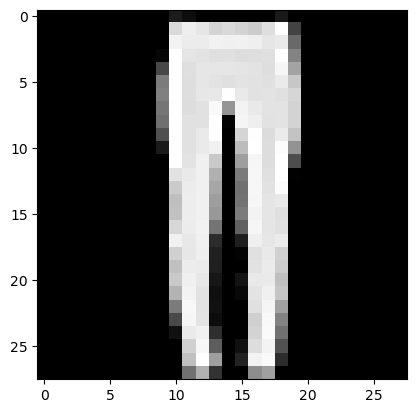

In [8]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Train GAN model

## Discriminator net

In [11]:
# change these if necesasry
image_size = 784
hidden_size = 256

In [12]:
# discriminator net
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## Generator net

In [13]:
# generator net
latent_size = 64
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [14]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

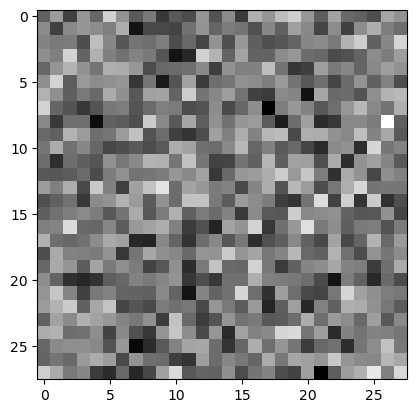

In [15]:
plt.imshow(gen_imgs[0], cmap='gray');


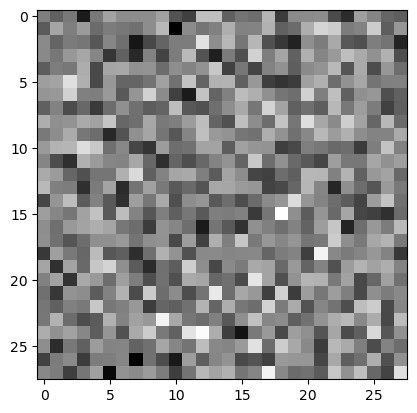

In [14]:
plt.imshow(gen_imgs[1], cmap='gray');

In [16]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

## Discriminator training

In [19]:
# discriminator is a binary classification problem
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [20]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

## Generator training

In [21]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## training the model

In [19]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

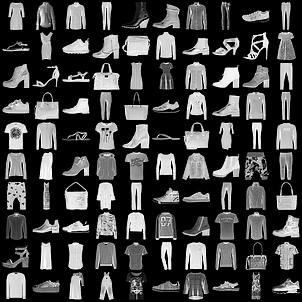

In [20]:


# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


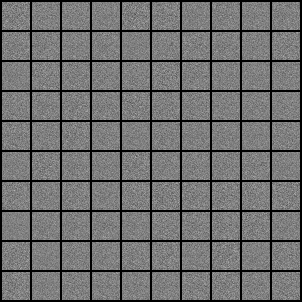

In [21]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [22]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0816, g_loss: 4.3892, D(x): 0.98, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.2150, g_loss: 5.2404, D(x): 0.92, D(G(z)): 0.09
Epoch [0/300], Step [600/600], d_loss: 0.0595, g_loss: 5.3130, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0657, g_loss: 3.9456, D(x): 0.98, D(G(z)): 0.05
Epoch [1/300], Step [400/600], d_loss: 0.0451, g_loss: 4.8570, D(x): 0.98, D(G(z)): 0.01
Epoch [1/300], Step [600/600], d_loss: 0.0296, g_loss: 5.2916, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0237, g_loss: 6.1062, D(x): 1.00, D(G(z)): 0.02
Epoch [2/300], Step [400/600], d_loss: 0.0837, g_loss: 5.5828, D(x): 0.99, D(G(z)): 0.01
Epoch [2/300], Step [600/600], d_loss: 0.0955, g_loss: 8.4313, D(x): 0.98, D(G(z)): 0.04
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0393, g_loss: 7.4493, D(x): 1.00, D(G(z)): 0.03
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.4758, g_loss: 3.0946, D(x): 0.87, D(G(z)): 0.15
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.5071, g_loss: 3.0746, D(x): 0.93, D(G(z)): 0.20
Epoch [28/300], Step [400/600], d_loss: 0.4388, g_loss: 2.7308, D(x): 0.85, D(G(z)): 0.13
Epoch [28/300], Step [600/600], d_loss: 0.6572, g_loss: 2.6344, D(x): 0.85, D(G(z)): 0.22
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.4487, g_loss: 2.9487, D(x): 0.86, D(G(z)): 0.15
Epoch [29/300], Step [400/600], d_loss: 0.7379, g_loss: 3.6625, D(x): 0.75, D(G(z)): 0.11
Epoch [29/300], Step [600/600], d_loss: 0.3371, g_loss: 3.9180, D(x): 0.91, D(G(z)): 0.11
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.4314, g_loss: 3.4160, D(x): 0.84, D(G(z)): 0.12
Epoch [30/300], Step [400/600], d_loss: 0.6148, g_loss: 3.1871, D(x): 0.74, D(G(z)): 0.08
Epoch [30/300], Step [600/600], d_loss: 0.7273, g_loss: 2.1652, D(x): 0.87, D(G(z)): 0.31
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.5070, g_loss: 2.6685, D(x): 0.88, D(G(z)): 0.24
Epoch [55/300], Step [600/600], d_loss: 0.5842, g_loss: 1.8461, D(x): 0.88, D(G(z)): 0.27
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.4636, g_loss: 2.7340, D(x): 0.80, D(G(z)): 0.13
Epoch [56/300], Step [400/600], d_loss: 0.6546, g_loss: 2.6551, D(x): 0.79, D(G(z)): 0.21
Epoch [56/300], Step [600/600], d_loss: 0.7340, g_loss: 2.6286, D(x): 0.78, D(G(z)): 0.24
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.4756, g_loss: 2.3704, D(x): 0.82, D(G(z)): 0.18
Epoch [57/300], Step [400/600], d_loss: 0.9211, g_loss: 1.8525, D(x): 0.76, D(G(z)): 0.27
Epoch [57/300], Step [600/600], d_loss: 0.4809, g_loss: 2.2735, D(x): 0.84, D(G(z)): 0.18
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.6420, g_loss: 2.6159, D(x): 0.83, D(G(z)): 0.20
Epoch [58/300], Step [400/600], d_loss: 0.9392, g_loss: 2.1667, D(x): 0.67, D(G(z)): 0.18
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 1.1438, g_loss: 1.5021, D(x): 0.79, D(G(z)): 0.45
Epoch [83/300], Step [400/600], d_loss: 1.1074, g_loss: 2.0966, D(x): 0.69, D(G(z)): 0.30
Epoch [83/300], Step [600/600], d_loss: 0.7518, g_loss: 1.7853, D(x): 0.72, D(G(z)): 0.21
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.7953, g_loss: 2.0841, D(x): 0.75, D(G(z)): 0.27
Epoch [84/300], Step [400/600], d_loss: 0.8528, g_loss: 1.7953, D(x): 0.83, D(G(z)): 0.35
Epoch [84/300], Step [600/600], d_loss: 0.7316, g_loss: 1.8321, D(x): 0.75, D(G(z)): 0.22
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.8121, g_loss: 2.1968, D(x): 0.77, D(G(z)): 0.27
Epoch [85/300], Step [400/600], d_loss: 0.6834, g_loss: 1.9207, D(x): 0.80, D(G(z)): 0.29
Epoch [85/300], Step [600/600], d_loss: 0.7737, g_loss: 2.0067, D(x): 0.81, D(G(z)): 0.29
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.9701, g_loss: 1.5808, D(x): 0.68, D(G(z)): 0.26
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 1.0969, g_loss: 1.3224, D(x): 0.69, D(G(z)): 0.36
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.9717, g_loss: 1.4500, D(x): 0.67, D(G(z)): 0.32
Epoch [111/300], Step [400/600], d_loss: 1.3551, g_loss: 1.5368, D(x): 0.59, D(G(z)): 0.38
Epoch [111/300], Step [600/600], d_loss: 0.8444, g_loss: 2.1501, D(x): 0.74, D(G(z)): 0.28
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.8850, g_loss: 2.1290, D(x): 0.77, D(G(z)): 0.32
Epoch [112/300], Step [400/600], d_loss: 0.7052, g_loss: 2.4951, D(x): 0.80, D(G(z)): 0.27
Epoch [112/300], Step [600/600], d_loss: 1.0648, g_loss: 1.5980, D(x): 0.71, D(G(z)): 0.37
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.8391, g_loss: 1.9060, D(x): 0.73, D(G(z)): 0.28
Epoch [113/300], Step [400/600], d_loss: 1.0492, g_loss: 1.7613, D(x): 0.68, D(G(z)): 0.35
Epoch [113/300], Step [600/600], d_loss: 0.7691, g_loss: 2.0370, D(x): 0.73, D(G(z)): 0.23
Saving

Epoch [138/300], Step [200/600], d_loss: 0.9567, g_loss: 1.3817, D(x): 0.73, D(G(z)): 0.37
Epoch [138/300], Step [400/600], d_loss: 0.8268, g_loss: 1.5878, D(x): 0.76, D(G(z)): 0.33
Epoch [138/300], Step [600/600], d_loss: 0.8903, g_loss: 1.5408, D(x): 0.66, D(G(z)): 0.27
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 1.0139, g_loss: 1.3546, D(x): 0.65, D(G(z)): 0.32
Epoch [139/300], Step [400/600], d_loss: 0.9725, g_loss: 1.5944, D(x): 0.69, D(G(z)): 0.34
Epoch [139/300], Step [600/600], d_loss: 1.0679, g_loss: 1.6226, D(x): 0.60, D(G(z)): 0.27
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 1.0485, g_loss: 1.4203, D(x): 0.68, D(G(z)): 0.36
Epoch [140/300], Step [400/600], d_loss: 1.0625, g_loss: 1.5437, D(x): 0.62, D(G(z)): 0.31
Epoch [140/300], Step [600/600], d_loss: 0.8316, g_loss: 1.3534, D(x): 0.74, D(G(z)): 0.32
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.9224, g_loss: 1.5705, D(x): 0.70, D(G(z)): 0.33
Epoch 

Epoch [165/300], Step [400/600], d_loss: 1.0666, g_loss: 1.9424, D(x): 0.59, D(G(z)): 0.24
Epoch [165/300], Step [600/600], d_loss: 1.1573, g_loss: 1.5675, D(x): 0.68, D(G(z)): 0.40
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.9978, g_loss: 1.4669, D(x): 0.67, D(G(z)): 0.33
Epoch [166/300], Step [400/600], d_loss: 1.2126, g_loss: 1.2632, D(x): 0.62, D(G(z)): 0.35
Epoch [166/300], Step [600/600], d_loss: 0.8366, g_loss: 1.6964, D(x): 0.75, D(G(z)): 0.33
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 1.1487, g_loss: 1.4252, D(x): 0.60, D(G(z)): 0.31
Epoch [167/300], Step [400/600], d_loss: 1.0974, g_loss: 1.2734, D(x): 0.64, D(G(z)): 0.37
Epoch [167/300], Step [600/600], d_loss: 0.9453, g_loss: 1.3834, D(x): 0.65, D(G(z)): 0.27
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.9618, g_loss: 1.3380, D(x): 0.68, D(G(z)): 0.34
Epoch [168/300], Step [400/600], d_loss: 0.9088, g_loss: 1.4281, D(x): 0.66, D(G(z)): 0.29
Epoch 

Epoch [192/300], Step [600/600], d_loss: 1.4621, g_loss: 1.2937, D(x): 0.59, D(G(z)): 0.43
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.6942, g_loss: 1.9465, D(x): 0.73, D(G(z)): 0.23
Epoch [193/300], Step [400/600], d_loss: 1.0728, g_loss: 1.1200, D(x): 0.70, D(G(z)): 0.38
Epoch [193/300], Step [600/600], d_loss: 1.0323, g_loss: 1.4586, D(x): 0.69, D(G(z)): 0.37
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 1.0332, g_loss: 2.0003, D(x): 0.61, D(G(z)): 0.28
Epoch [194/300], Step [400/600], d_loss: 1.0970, g_loss: 1.2950, D(x): 0.66, D(G(z)): 0.36
Epoch [194/300], Step [600/600], d_loss: 1.0005, g_loss: 1.3310, D(x): 0.63, D(G(z)): 0.32
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 1.1857, g_loss: 1.1903, D(x): 0.62, D(G(z)): 0.39
Epoch [195/300], Step [400/600], d_loss: 0.9378, g_loss: 1.4748, D(x): 0.67, D(G(z)): 0.33
Epoch [195/300], Step [600/600], d_loss: 1.1196, g_loss: 1.3139, D(x): 0.54, D(G(z)): 0.28
Saving

Epoch [220/300], Step [200/600], d_loss: 1.2638, g_loss: 1.1059, D(x): 0.56, D(G(z)): 0.38
Epoch [220/300], Step [400/600], d_loss: 0.7932, g_loss: 1.6381, D(x): 0.71, D(G(z)): 0.28
Epoch [220/300], Step [600/600], d_loss: 1.1264, g_loss: 1.2675, D(x): 0.66, D(G(z)): 0.39
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 1.1249, g_loss: 1.3429, D(x): 0.60, D(G(z)): 0.35
Epoch [221/300], Step [400/600], d_loss: 1.1757, g_loss: 1.5110, D(x): 0.59, D(G(z)): 0.33
Epoch [221/300], Step [600/600], d_loss: 1.0314, g_loss: 1.1828, D(x): 0.65, D(G(z)): 0.36
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.8579, g_loss: 1.6397, D(x): 0.72, D(G(z)): 0.31
Epoch [222/300], Step [400/600], d_loss: 0.8975, g_loss: 1.4398, D(x): 0.67, D(G(z)): 0.30
Epoch [222/300], Step [600/600], d_loss: 1.2802, g_loss: 1.2653, D(x): 0.58, D(G(z)): 0.37
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 1.1744, g_loss: 1.1218, D(x): 0.61, D(G(z)): 0.38
Epoch 

Epoch [247/300], Step [400/600], d_loss: 1.4090, g_loss: 0.9670, D(x): 0.58, D(G(z)): 0.43
Epoch [247/300], Step [600/600], d_loss: 1.2968, g_loss: 1.0409, D(x): 0.60, D(G(z)): 0.43
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 1.0506, g_loss: 1.1473, D(x): 0.62, D(G(z)): 0.32
Epoch [248/300], Step [400/600], d_loss: 0.9397, g_loss: 1.1750, D(x): 0.69, D(G(z)): 0.34
Epoch [248/300], Step [600/600], d_loss: 0.9371, g_loss: 1.4330, D(x): 0.63, D(G(z)): 0.29
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 1.2751, g_loss: 1.0648, D(x): 0.57, D(G(z)): 0.41
Epoch [249/300], Step [400/600], d_loss: 1.0593, g_loss: 1.1725, D(x): 0.64, D(G(z)): 0.38
Epoch [249/300], Step [600/600], d_loss: 1.0653, g_loss: 1.3877, D(x): 0.63, D(G(z)): 0.33
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.9347, g_loss: 1.1958, D(x): 0.67, D(G(z)): 0.32
Epoch [250/300], Step [400/600], d_loss: 1.3783, g_loss: 1.1150, D(x): 0.59, D(G(z)): 0.44
Epoch 

Epoch [274/300], Step [600/600], d_loss: 1.3646, g_loss: 0.9987, D(x): 0.65, D(G(z)): 0.50
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.7932, g_loss: 1.6064, D(x): 0.70, D(G(z)): 0.27
Epoch [275/300], Step [400/600], d_loss: 1.1417, g_loss: 1.3777, D(x): 0.59, D(G(z)): 0.35
Epoch [275/300], Step [600/600], d_loss: 1.1138, g_loss: 1.0645, D(x): 0.65, D(G(z)): 0.38
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.8957, g_loss: 1.5399, D(x): 0.67, D(G(z)): 0.29
Epoch [276/300], Step [400/600], d_loss: 1.1281, g_loss: 1.2602, D(x): 0.61, D(G(z)): 0.39
Epoch [276/300], Step [600/600], d_loss: 0.7327, g_loss: 1.5985, D(x): 0.76, D(G(z)): 0.31
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 1.1084, g_loss: 1.1458, D(x): 0.62, D(G(z)): 0.37
Epoch [277/300], Step [400/600], d_loss: 1.0896, g_loss: 1.3045, D(x): 0.61, D(G(z)): 0.33
Epoch [277/300], Step [600/600], d_loss: 1.1444, g_loss: 0.9649, D(x): 0.64, D(G(z)): 0.39
Saving

In [ ]:
### show some of the images from the folder created for part 3
### Change the png #s later

## Displaying 3 samples from the GAN model

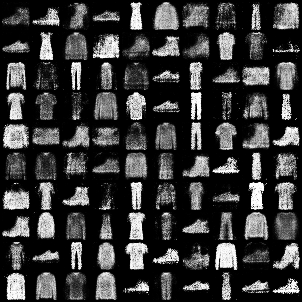

In [23]:
# At 100 epochs
Image('./samples/fake_images-0100.png')

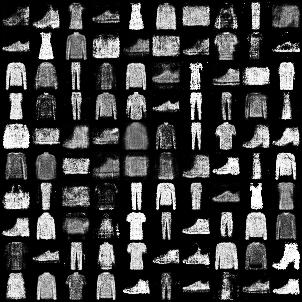

In [24]:
# At 200 epochs
Image('./samples/fake_images-0200.png')

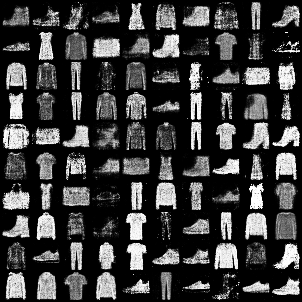

In [25]:
# at 300 epochs
Image('./samples/fake_images-0300.png')

One issue with this strategy is that each output has many images in it. This makes it harder to look closely at a single object. Outside of this, there was not any specific difficulties in this process.

## Saving and loading model weights using checkpoints

In [32]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [25]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training
D = D
G = G


D.load_state_dict(torch.load('./D.ckpt', weights_only=True))
G.load_state_dict(torch.load('./G.ckpt', weights_only=True))

print(D)
print('\n')
print(G)


Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)


Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)


Saving fake_images-0301.png


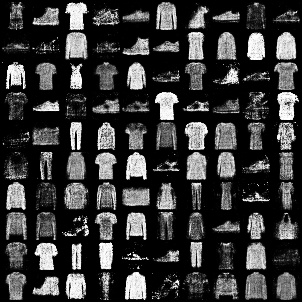

In [26]:
# Showing that the model was saved and loaded

sample_vectors = torch.randn(batch_size, latent_size).to(device)
sample_dir = 'samples'

# Using generate, which was loaded from checkpoint
fake_images = G(sample_vectors)
fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
fake_fname = 'fake_images-{0:0=4d}.png'.format(301)
print('Saving', fake_fname)
save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
Image(os.path.join(sample_dir, 'fake_images-0301.png'))

## Trying to improve GAN model

Without changing the type of GAN (since there are many types such as LSGAN, DCGAN, etc.). After loading the model from the checkpoints, we continue training it. The learning rate for the optimizer has been changed, and I train for an additional 50 epochs.

In [27]:
%%time
D.to(device)
G.to(device)

# discriminator is a binary classification problem
criterion = nn.BCELoss()
# Changing the learning rate
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0004)

sample_dir = 'new_samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

    

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))
    
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

# changing learning rate
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0004)
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Saving fake_images-0000.png
Epoch [0/50], Step [200/600], d_loss: 1.7735, g_loss: 1.2931, D(x): 0.54, D(G(z)): 0.44
Epoch [0/50], Step [400/600], d_loss: 0.8545, g_loss: 3.0069, D(x): 0.82, D(G(z)): 0.28
Epoch [0/50], Step [600/600], d_loss: 1.1401, g_loss: 2.2402, D(x): 0.71, D(G(z)): 0.32
Saving fake_images-0001.png
Epoch [1/50], Step [200/600], d_loss: 1.1339, g_loss: 1.9205, D(x): 0.72, D(G(z)): 0.31
Epoch [1/50], Step [400/600], d_loss: 1.5404, g_loss: 1.5901, D(x): 0.57, D(G(z)): 0.32
Epoch [1/50], Step [600/600], d_loss: 1.2363, g_loss: 1.6572, D(x): 0.57, D(G(z)): 0.31
Saving fake_images-0002.png
Epoch [2/50], Step [200/600], d_loss: 1.2268, g_loss: 1.2576, D(x): 0.60, D(G(z)): 0.41
Epoch [2/50], Step [400/600], d_loss: 1.2907, g_loss: 1.1195, D(x): 0.58, D(G(z)): 0.40
Epoch [2/50], Step [600/600], d_loss: 1.3018, g_loss: 0.9352, D(x): 0.62, D(G(z)): 0.45
Saving fake_images-0003.png
Epoch [3/50], Step [200/600], d_loss: 1.2183, g_loss: 1.2954, D(x): 0.57, D(G(z)): 0.35
Epoch [3

Epoch [28/50], Step [200/600], d_loss: 2.0506, g_loss: 0.7707, D(x): 0.41, D(G(z)): 0.54
Epoch [28/50], Step [400/600], d_loss: 1.1485, g_loss: 1.0395, D(x): 0.65, D(G(z)): 0.44
Epoch [28/50], Step [600/600], d_loss: 1.6107, g_loss: 0.9205, D(x): 0.47, D(G(z)): 0.49
Saving fake_images-0029.png
Epoch [29/50], Step [200/600], d_loss: 1.0580, g_loss: 1.2395, D(x): 0.62, D(G(z)): 0.35
Epoch [29/50], Step [400/600], d_loss: 1.3206, g_loss: 0.9982, D(x): 0.53, D(G(z)): 0.42
Epoch [29/50], Step [600/600], d_loss: 1.1611, g_loss: 1.0474, D(x): 0.58, D(G(z)): 0.40
Saving fake_images-0030.png
Epoch [30/50], Step [200/600], d_loss: 1.1286, g_loss: 0.9489, D(x): 0.65, D(G(z)): 0.44
Epoch [30/50], Step [400/600], d_loss: 1.7119, g_loss: 0.9267, D(x): 0.43, D(G(z)): 0.43
Epoch [30/50], Step [600/600], d_loss: 1.1334, g_loss: 1.1365, D(x): 0.59, D(G(z)): 0.35
Saving fake_images-0031.png
Epoch [31/50], Step [200/600], d_loss: 1.0732, g_loss: 1.2147, D(x): 0.59, D(G(z)): 0.34
Epoch [31/50], Step [400/6

Based on the initial loss, we can see that the model is starting its training from the end of the original. Additionally, the scores for D(x) and D(G(z)) have improved.

## Saving the model without checkpoints 

In [29]:
# Saving the entire model instead of using a checkpoint
torch.save(G, 'g_model')
torch.save(D, 'd_model')



In [30]:
loaded_g = torch.load('./g_model', weights_only=False)
loaded_d = torch.load('./d_model', weights_only=False)

print(loaded_g)
print('\n')
print(loaded_d)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)


Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)


Saving fake_images-0301.png


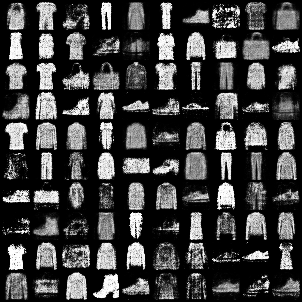

In [31]:
# Showing that the model was saved and loaded

sample_vectors = torch.randn(batch_size, latent_size).to(device)
sample_dir = 'new_samples'

# Using loaded_lsg, which was loaded from checkpoint
fake_images = loaded_g(sample_vectors)
fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
fake_fname = 'fake_images-{0:0=4d}.png'.format(301)
print('Saving', fake_fname)
save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
Image(os.path.join(sample_dir, 'fake_images-0301.png'))

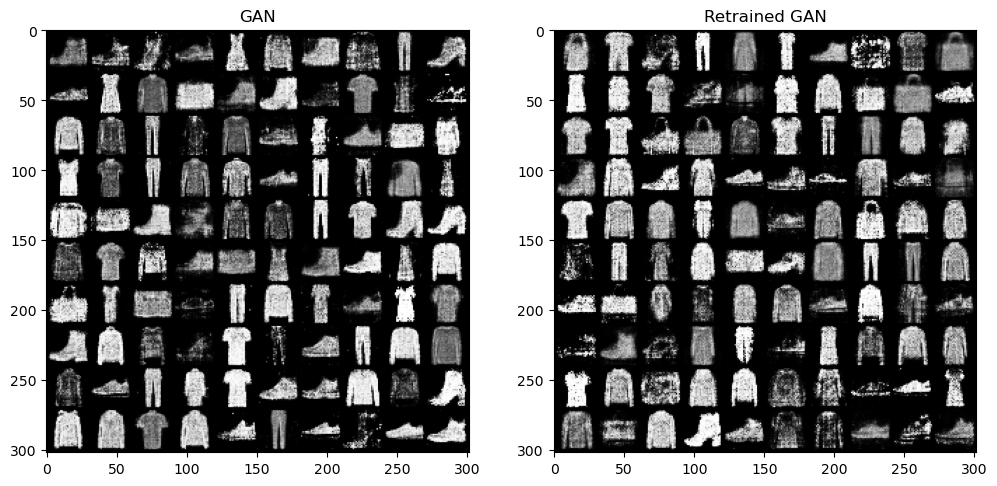

In [35]:
# Showing the difference in generated images between old and additional training
im1 = plt.imread('./samples/fake_images-0300.png')
im2 = plt.imread('./new_samples/fake_images-0301.png')
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(im1)
axes[1].imshow(im2)
axes[0].set_title('GAN')
axes[1].set_title('Retrained GAN')
plt.show()

#Image('./samples/fake_images-0100.png')
#Image('./LS_Samples/fake_images-0100.png')

The model itself seemed to improve its scores, but the generated images don't seem that much better.

# Least Squares GAN

The fashion mnist dataset is already loaded from the beginning.

Similar to normal GAN, but discriminator does not need sigmoid layer, and the loss function is MSE

In [26]:
%%time

# Discriminator doesnt need the sigmoid layer for LSGAN
# discriminator net
LS_D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1))

LS_D.to(device)

# generator net
latent_size = 64
LS_G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

LS_G.to(device)

# discriminator is a binary classification problem
d_optimizer = torch.optim.Adam(LS_D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(LS_G.parameters(), lr=0.0002)

# change loss function to least square (MSE)
LS_criterion = nn.MSELoss()

import os
sample_dir = 'LS_Samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)



# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_ls_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = LS_D(images)
    d_loss_real = LS_criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = LS_G(z)
    outputs = LS_D(fake_images)
    d_loss_fake = LS_criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

def train_ls_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = LS_G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = LS_criterion(LS_D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = LS_G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_ls_discriminator(images)
        g_loss, fake_images = train_ls_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)



Epoch [0/300], Step [200/600], d_loss: 0.0081, g_loss: 1.1354, D(x): 1.00, D(G(z)): 0.01
Epoch [0/300], Step [400/600], d_loss: 0.0125, g_loss: 1.2920, D(x): 1.01, D(G(z)): -0.00
Epoch [0/300], Step [600/600], d_loss: 0.0044, g_loss: 1.1157, D(x): 1.01, D(G(z)): 0.01
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0077, g_loss: 1.1637, D(x): 1.01, D(G(z)): 0.04
Epoch [1/300], Step [400/600], d_loss: 0.0031, g_loss: 1.0848, D(x): 1.00, D(G(z)): -0.00
Epoch [1/300], Step [600/600], d_loss: 0.0018, g_loss: 1.0300, D(x): 1.00, D(G(z)): -0.00
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0009, g_loss: 1.0441, D(x): 1.00, D(G(z)): -0.00
Epoch [2/300], Step [400/600], d_loss: 0.0016, g_loss: 1.0141, D(x): 0.99, D(G(z)): 0.00
Epoch [2/300], Step [600/600], d_loss: 0.0007, g_loss: 1.0138, D(x): 1.01, D(G(z)): 0.01
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0006, g_loss: 1.0221, D(x): 0.99, D(G(z)): 0.01
Epoch [3/300], Step [4

Epoch [27/300], Step [600/600], d_loss: 0.1191, g_loss: 1.1121, D(x): 0.83, D(G(z)): 0.11
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.1040, g_loss: 0.9207, D(x): 0.81, D(G(z)): 0.08
Epoch [28/300], Step [400/600], d_loss: 0.0741, g_loss: 1.0275, D(x): 0.98, D(G(z)): 0.12
Epoch [28/300], Step [600/600], d_loss: 0.1170, g_loss: 0.8318, D(x): 0.92, D(G(z)): 0.20
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.1105, g_loss: 0.8248, D(x): 0.88, D(G(z)): 0.12
Epoch [29/300], Step [400/600], d_loss: 0.0738, g_loss: 0.9856, D(x): 0.94, D(G(z)): 0.07
Epoch [29/300], Step [600/600], d_loss: 0.0982, g_loss: 0.9659, D(x): 0.95, D(G(z)): 0.09
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.0972, g_loss: 0.9471, D(x): 0.90, D(G(z)): 0.04
Epoch [30/300], Step [400/600], d_loss: 0.0797, g_loss: 0.7978, D(x): 0.90, D(G(z)): 0.10
Epoch [30/300], Step [600/600], d_loss: 0.1119, g_loss: 0.8565, D(x): 0.93, D(G(z)): 0.18
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.1496, g_loss: 0.6998, D(x): 0.81, D(G(z)): 0.15
Epoch [55/300], Step [600/600], d_loss: 0.2688, g_loss: 0.6777, D(x): 0.67, D(G(z)): 0.14
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.1575, g_loss: 0.7208, D(x): 0.88, D(G(z)): 0.21
Epoch [56/300], Step [400/600], d_loss: 0.2018, g_loss: 0.6919, D(x): 0.73, D(G(z)): 0.13
Epoch [56/300], Step [600/600], d_loss: 0.2454, g_loss: 0.8012, D(x): 0.73, D(G(z)): 0.21
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.1473, g_loss: 0.7233, D(x): 0.79, D(G(z)): 0.11
Epoch [57/300], Step [400/600], d_loss: 0.1350, g_loss: 0.8341, D(x): 0.88, D(G(z)): 0.18
Epoch [57/300], Step [600/600], d_loss: 0.1570, g_loss: 0.6333, D(x): 0.88, D(G(z)): 0.25
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.1847, g_loss: 0.7072, D(x): 0.76, D(G(z)): 0.17
Epoch [58/300], Step [400/600], d_loss: 0.1901, g_loss: 0.7471, D(x): 0.79, D(G(z)): 0.21
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.1451, g_loss: 0.8544, D(x): 0.93, D(G(z)): 0.16
Epoch [83/300], Step [400/600], d_loss: 0.2330, g_loss: 0.5935, D(x): 0.69, D(G(z)): 0.23
Epoch [83/300], Step [600/600], d_loss: 0.2114, g_loss: 0.7959, D(x): 0.82, D(G(z)): 0.30
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.1627, g_loss: 0.8006, D(x): 0.82, D(G(z)): 0.14
Epoch [84/300], Step [400/600], d_loss: 0.1664, g_loss: 0.8928, D(x): 0.82, D(G(z)): 0.16
Epoch [84/300], Step [600/600], d_loss: 0.1942, g_loss: 0.6592, D(x): 0.92, D(G(z)): 0.25
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.2945, g_loss: 0.6515, D(x): 0.71, D(G(z)): 0.30
Epoch [85/300], Step [400/600], d_loss: 0.2795, g_loss: 0.4829, D(x): 0.77, D(G(z)): 0.32
Epoch [85/300], Step [600/600], d_loss: 0.1891, g_loss: 0.7340, D(x): 0.82, D(G(z)): 0.18
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.1925, g_loss: 0.8776, D(x): 0.81, D(G(z)): 0.21
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.2502, g_loss: 0.7018, D(x): 0.83, D(G(z)): 0.28
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.1756, g_loss: 0.7681, D(x): 0.80, D(G(z)): 0.16
Epoch [111/300], Step [400/600], d_loss: 0.2665, g_loss: 0.5842, D(x): 0.71, D(G(z)): 0.27
Epoch [111/300], Step [600/600], d_loss: 0.3256, g_loss: 0.5790, D(x): 0.73, D(G(z)): 0.35
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.1449, g_loss: 0.7421, D(x): 0.80, D(G(z)): 0.13
Epoch [112/300], Step [400/600], d_loss: 0.2798, g_loss: 0.6065, D(x): 0.77, D(G(z)): 0.32
Epoch [112/300], Step [600/600], d_loss: 0.1774, g_loss: 0.8471, D(x): 0.88, D(G(z)): 0.21
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.2366, g_loss: 0.6462, D(x): 0.73, D(G(z)): 0.22
Epoch [113/300], Step [400/600], d_loss: 0.2218, g_loss: 0.7441, D(x): 0.78, D(G(z)): 0.21
Epoch [113/300], Step [600/600], d_loss: 0.2894, g_loss: 0.4981, D(x): 0.76, D(G(z)): 0.33
Saving

Epoch [138/300], Step [200/600], d_loss: 0.1873, g_loss: 0.7342, D(x): 0.79, D(G(z)): 0.19
Epoch [138/300], Step [400/600], d_loss: 0.1849, g_loss: 0.6611, D(x): 0.86, D(G(z)): 0.19
Epoch [138/300], Step [600/600], d_loss: 0.3363, g_loss: 0.5179, D(x): 0.61, D(G(z)): 0.24
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.2006, g_loss: 0.6799, D(x): 0.73, D(G(z)): 0.17
Epoch [139/300], Step [400/600], d_loss: 0.1826, g_loss: 0.7945, D(x): 0.81, D(G(z)): 0.20
Epoch [139/300], Step [600/600], d_loss: 0.2563, g_loss: 0.6075, D(x): 0.85, D(G(z)): 0.32
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.2372, g_loss: 0.6995, D(x): 0.72, D(G(z)): 0.26
Epoch [140/300], Step [400/600], d_loss: 0.2732, g_loss: 0.6264, D(x): 0.71, D(G(z)): 0.30
Epoch [140/300], Step [600/600], d_loss: 0.1737, g_loss: 0.7229, D(x): 0.86, D(G(z)): 0.19
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.1836, g_loss: 0.8124, D(x): 0.83, D(G(z)): 0.21
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.2504, g_loss: 0.6914, D(x): 0.79, D(G(z)): 0.30
Epoch [165/300], Step [600/600], d_loss: 0.2421, g_loss: 0.5611, D(x): 0.81, D(G(z)): 0.31
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.3143, g_loss: 0.4522, D(x): 0.76, D(G(z)): 0.37
Epoch [166/300], Step [400/600], d_loss: 0.3096, g_loss: 0.4672, D(x): 0.71, D(G(z)): 0.34
Epoch [166/300], Step [600/600], d_loss: 0.2424, g_loss: 0.6054, D(x): 0.79, D(G(z)): 0.30
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.2121, g_loss: 0.7802, D(x): 0.77, D(G(z)): 0.15
Epoch [167/300], Step [400/600], d_loss: 0.3154, g_loss: 0.5588, D(x): 0.70, D(G(z)): 0.29
Epoch [167/300], Step [600/600], d_loss: 0.2431, g_loss: 0.6009, D(x): 0.80, D(G(z)): 0.31
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.1836, g_loss: 0.8587, D(x): 0.82, D(G(z)): 0.10
Epoch [168/300], Step [400/600], d_loss: 0.2021, g_loss: 0.6223, D(x): 0.85, D(G(z)): 0.26
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.1759, g_loss: 0.7937, D(x): 0.80, D(G(z)): 0.18
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.2046, g_loss: 0.6626, D(x): 0.84, D(G(z)): 0.25
Epoch [193/300], Step [400/600], d_loss: 0.2936, g_loss: 0.6910, D(x): 0.68, D(G(z)): 0.29
Epoch [193/300], Step [600/600], d_loss: 0.3269, g_loss: 0.5134, D(x): 0.67, D(G(z)): 0.32
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.3248, g_loss: 0.5342, D(x): 0.64, D(G(z)): 0.31
Epoch [194/300], Step [400/600], d_loss: 0.2266, g_loss: 0.6424, D(x): 0.72, D(G(z)): 0.25
Epoch [194/300], Step [600/600], d_loss: 0.2691, g_loss: 0.4997, D(x): 0.75, D(G(z)): 0.32
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.2354, g_loss: 0.5807, D(x): 0.76, D(G(z)): 0.23
Epoch [195/300], Step [400/600], d_loss: 0.1736, g_loss: 0.7531, D(x): 0.84, D(G(z)): 0.21
Epoch [195/300], Step [600/600], d_loss: 0.2544, g_loss: 0.5570, D(x): 0.74, D(G(z)): 0.27
Saving

Epoch [220/300], Step [200/600], d_loss: 0.3226, g_loss: 0.5160, D(x): 0.77, D(G(z)): 0.36
Epoch [220/300], Step [400/600], d_loss: 0.1583, g_loss: 0.8344, D(x): 0.85, D(G(z)): 0.18
Epoch [220/300], Step [600/600], d_loss: 0.2277, g_loss: 0.6984, D(x): 0.73, D(G(z)): 0.22
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.2536, g_loss: 0.5854, D(x): 0.74, D(G(z)): 0.25
Epoch [221/300], Step [400/600], d_loss: 0.2136, g_loss: 0.6390, D(x): 0.83, D(G(z)): 0.27
Epoch [221/300], Step [600/600], d_loss: 0.2587, g_loss: 0.5631, D(x): 0.79, D(G(z)): 0.29
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.2489, g_loss: 0.6139, D(x): 0.81, D(G(z)): 0.30
Epoch [222/300], Step [400/600], d_loss: 0.2542, g_loss: 0.6295, D(x): 0.73, D(G(z)): 0.21
Epoch [222/300], Step [600/600], d_loss: 0.2680, g_loss: 0.5855, D(x): 0.74, D(G(z)): 0.25
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.2063, g_loss: 0.7295, D(x): 0.81, D(G(z)): 0.23
Epoch 

Epoch [247/300], Step [400/600], d_loss: 0.2391, g_loss: 0.5639, D(x): 0.73, D(G(z)): 0.24
Epoch [247/300], Step [600/600], d_loss: 0.2677, g_loss: 0.6909, D(x): 0.69, D(G(z)): 0.26
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.2721, g_loss: 0.5806, D(x): 0.77, D(G(z)): 0.29
Epoch [248/300], Step [400/600], d_loss: 0.2457, g_loss: 0.6159, D(x): 0.88, D(G(z)): 0.34
Epoch [248/300], Step [600/600], d_loss: 0.2554, g_loss: 0.6125, D(x): 0.74, D(G(z)): 0.26
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.2476, g_loss: 0.6585, D(x): 0.72, D(G(z)): 0.21
Epoch [249/300], Step [400/600], d_loss: 0.2278, g_loss: 0.6525, D(x): 0.78, D(G(z)): 0.26
Epoch [249/300], Step [600/600], d_loss: 0.2738, g_loss: 0.6506, D(x): 0.78, D(G(z)): 0.25
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.2598, g_loss: 0.6755, D(x): 0.72, D(G(z)): 0.22
Epoch [250/300], Step [400/600], d_loss: 0.2597, g_loss: 0.6114, D(x): 0.71, D(G(z)): 0.25
Epoch 

Epoch [274/300], Step [600/600], d_loss: 0.2755, g_loss: 0.6096, D(x): 0.73, D(G(z)): 0.24
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.2775, g_loss: 0.6970, D(x): 0.72, D(G(z)): 0.25
Epoch [275/300], Step [400/600], d_loss: 0.1981, g_loss: 0.6581, D(x): 0.80, D(G(z)): 0.22
Epoch [275/300], Step [600/600], d_loss: 0.2728, g_loss: 0.6418, D(x): 0.77, D(G(z)): 0.26
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.2791, g_loss: 0.5307, D(x): 0.73, D(G(z)): 0.32
Epoch [276/300], Step [400/600], d_loss: 0.2945, g_loss: 0.5259, D(x): 0.69, D(G(z)): 0.28
Epoch [276/300], Step [600/600], d_loss: 0.2287, g_loss: 0.6634, D(x): 0.77, D(G(z)): 0.17
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.2322, g_loss: 0.6725, D(x): 0.73, D(G(z)): 0.19
Epoch [277/300], Step [400/600], d_loss: 0.3110, g_loss: 0.5670, D(x): 0.67, D(G(z)): 0.24
Epoch [277/300], Step [600/600], d_loss: 0.2353, g_loss: 0.6554, D(x): 0.78, D(G(z)): 0.25
Saving

## Saving and Loading Model Weights

Note: I messed up and misread the directions. I saved the model itself instead of saving by checkpoint, but I ran out of time to fix it.

In [37]:
# Saving the entire model instead of using a checkpoint
torch.save(LS_G, 'lsg_model')
torch.save(LS_D, 'lsd_model')



Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)


Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
)


## Showing 3 samples from the LSGAN

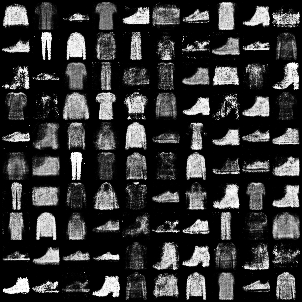

In [27]:
Image('./LS_Samples/fake_images-0100.png')

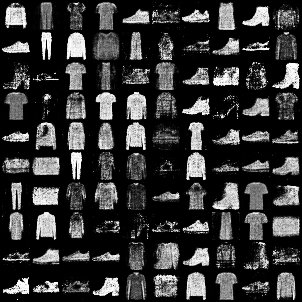

In [28]:
Image('./LS_Samples/fake_images-0200.png')

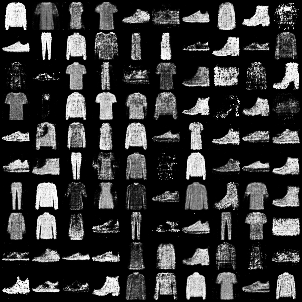

In [29]:
Image('./LS_Samples/fake_images-0300.png')

loading the model

In [36]:
loaded_lsg = torch.load('./lsg_model', weights_only=False)
loaded_lsd = torch.load('./lsd_model', weights_only=False)

print(loaded_lsg)
print('\n')
print(loaded_lsd)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)


Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
)


Saving fake_images-0301.png


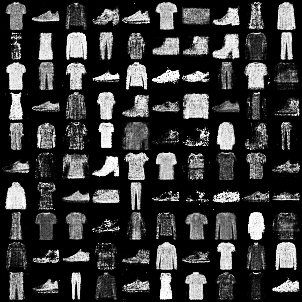

In [24]:
# Showing that the model was saved and loaded

sample_vectors = torch.randn(batch_size, latent_size).to(device)
sample_dir = 'LS_Samples'

# Using loaded_lsg, which was loaded from checkpoint
fake_images = loaded_lsg(sample_vectors)
fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
fake_fname = 'fake_images-{0:0=4d}.png'.format(301)
print('Saving', fake_fname)
save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
Image(os.path.join(sample_dir, 'fake_images-0301.png'))

## Comparing GAN and LSGAN (Original)

Comparing the original GAN and original LSGAN 

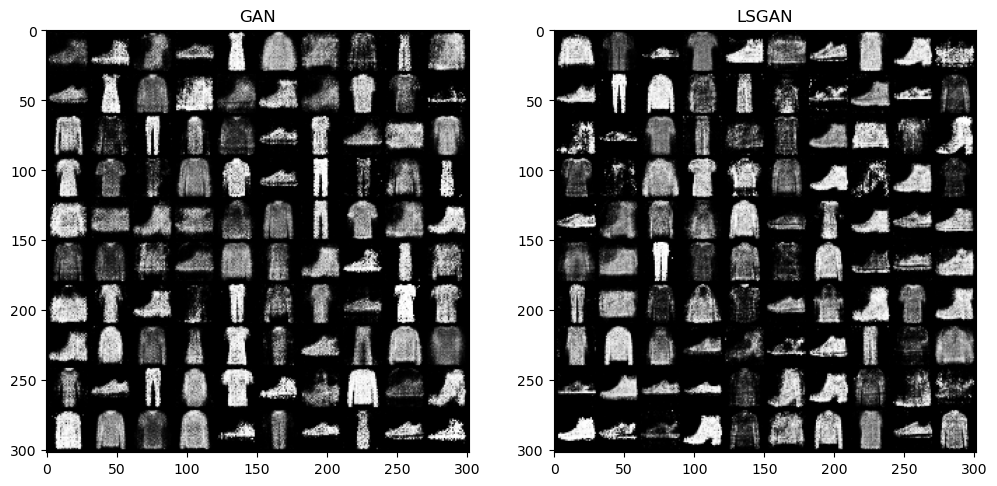

In [39]:
im1 = plt.imread('./samples/fake_images-0100.png')
im2 = plt.imread('./LS_Samples/fake_images-0100.png')
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(im1)
axes[1].imshow(im2)
axes[0].set_title('GAN')
axes[1].set_title('LSGAN')
plt.show()

#Image('./samples/fake_images-0100.png')
#Image('./LS_Samples/fake_images-0100.png')

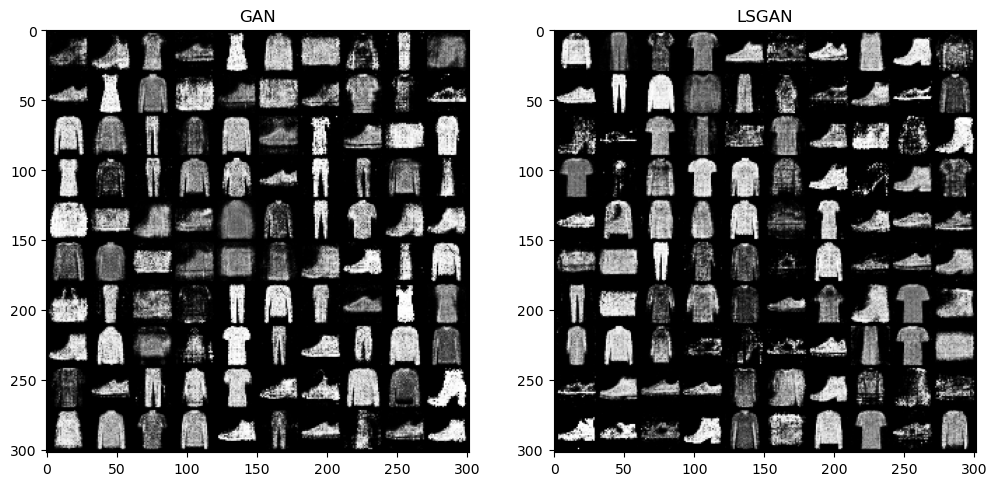

In [40]:
im1 = plt.imread('./samples/fake_images-0200.png')
im2 = plt.imread('./LS_Samples/fake_images-0200.png')
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(im1)
axes[1].imshow(im2)
axes[0].set_title('GAN')
axes[1].set_title('LSGAN')
plt.show()

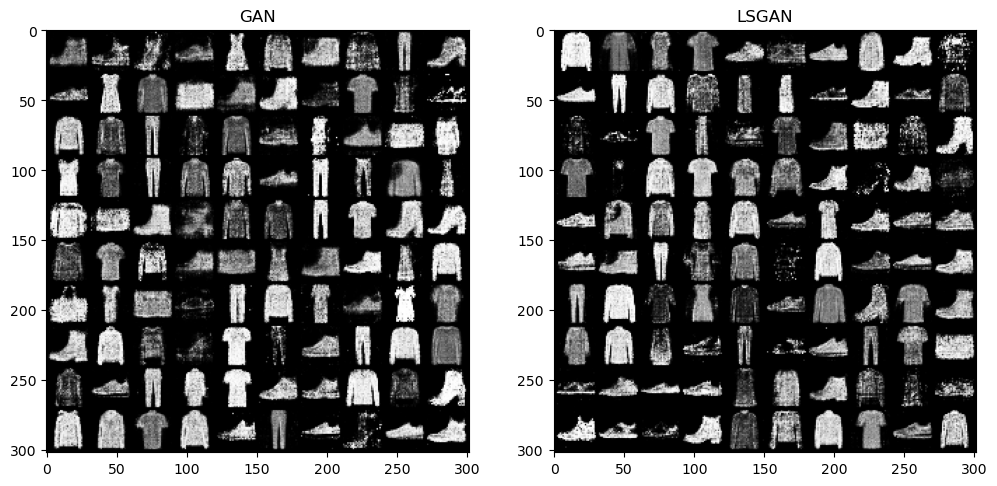

In [41]:
im1 = plt.imread('./samples/fake_images-0300.png')
im2 = plt.imread('./LS_Samples/fake_images-0300.png')
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(im1)
axes[1].imshow(im2)
axes[0].set_title('GAN')
axes[1].set_title('LSGAN')
plt.show()

LSGAN looks less grainy than GAN does. Addtionally, the images seem to have more detail. 

## Retraining LSGAN

Similar to the GAN retrain, I loaded the previous model, and changed the learning rate/epochs.

In [37]:
loaded_lsg = torch.load('./lsg_model', weights_only=False)
loaded_lsd = torch.load('./lsd_model', weights_only=False)

print(loaded_lsg)
print('\n')
print(loaded_lsd)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)


Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
)


Retraining the model

In [38]:
%%time


loaded_lsg.to(device)

loaded_lsd.to(device)

# discriminator is a binary classification problem
d_optimizer = torch.optim.Adam(loaded_lsd.parameters(), lr=0.0004)
g_optimizer = torch.optim.Adam(loaded_lsg.parameters(), lr=0.0004)

# change loss function to least square (MSE)
LS_criterion = nn.MSELoss()

import os
sample_dir = 'new_LS_Samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)



# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_ls_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = loaded_lsd(images)
    d_loss_real = LS_criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = loaded_lsg(z)
    outputs = loaded_lsd(fake_images)
    d_loss_fake = LS_criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

def train_ls_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = loaded_lsg(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = LS_criterion(loaded_lsd(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = loaded_lsg(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_ls_discriminator(images)
        g_loss, fake_images = train_ls_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)



Epoch [0/50], Step [200/600], d_loss: 0.3173, g_loss: 0.8651, D(x): 0.79, D(G(z)): 0.15
Epoch [0/50], Step [400/600], d_loss: 0.3432, g_loss: 0.5573, D(x): 0.73, D(G(z)): 0.34
Epoch [0/50], Step [600/600], d_loss: 0.2147, g_loss: 0.9490, D(x): 0.85, D(G(z)): 0.15
Saving fake_images-0001.png
Epoch [1/50], Step [200/600], d_loss: 0.2819, g_loss: 0.7046, D(x): 0.69, D(G(z)): 0.21
Epoch [1/50], Step [400/600], d_loss: 0.2269, g_loss: 0.7139, D(x): 0.82, D(G(z)): 0.23
Epoch [1/50], Step [600/600], d_loss: 0.3076, g_loss: 0.7119, D(x): 0.71, D(G(z)): 0.23
Saving fake_images-0002.png
Epoch [2/50], Step [200/600], d_loss: 0.3012, g_loss: 0.6294, D(x): 0.72, D(G(z)): 0.26
Epoch [2/50], Step [400/600], d_loss: 0.2228, g_loss: 0.7618, D(x): 0.73, D(G(z)): 0.20
Epoch [2/50], Step [600/600], d_loss: 0.2340, g_loss: 0.6325, D(x): 0.80, D(G(z)): 0.24
Saving fake_images-0003.png
Epoch [3/50], Step [200/600], d_loss: 0.2448, g_loss: 0.5983, D(x): 0.71, D(G(z)): 0.23
Epoch [3/50], Step [400/600], d_loss

Epoch [28/50], Step [200/600], d_loss: 0.3337, g_loss: 0.5824, D(x): 0.66, D(G(z)): 0.32
Epoch [28/50], Step [400/600], d_loss: 0.3367, g_loss: 0.7673, D(x): 0.66, D(G(z)): 0.21
Epoch [28/50], Step [600/600], d_loss: 0.3514, g_loss: 0.5898, D(x): 0.58, D(G(z)): 0.22
Saving fake_images-0029.png
Epoch [29/50], Step [200/600], d_loss: 0.2382, g_loss: 0.6143, D(x): 0.72, D(G(z)): 0.25
Epoch [29/50], Step [400/600], d_loss: 0.3401, g_loss: 0.5524, D(x): 0.64, D(G(z)): 0.27
Epoch [29/50], Step [600/600], d_loss: 0.3412, g_loss: 0.7186, D(x): 0.68, D(G(z)): 0.23
Saving fake_images-0030.png
Epoch [30/50], Step [200/600], d_loss: 0.3189, g_loss: 0.4981, D(x): 0.67, D(G(z)): 0.32
Epoch [30/50], Step [400/600], d_loss: 0.2893, g_loss: 0.4785, D(x): 0.75, D(G(z)): 0.33
Epoch [30/50], Step [600/600], d_loss: 0.2893, g_loss: 0.4870, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0031.png
Epoch [31/50], Step [200/600], d_loss: 0.4684, g_loss: 0.4757, D(x): 0.52, D(G(z)): 0.28
Epoch [31/50], Step [400/6

Similar to the retrained GAN, we can see that we have loaded the model correctly, since the losses are consistent with the losses from the end of the initial training.
The retrained LSGAN seems to have performed better based on the losses from the last few epochs.

## Comparing LSGAN and new LSGAN

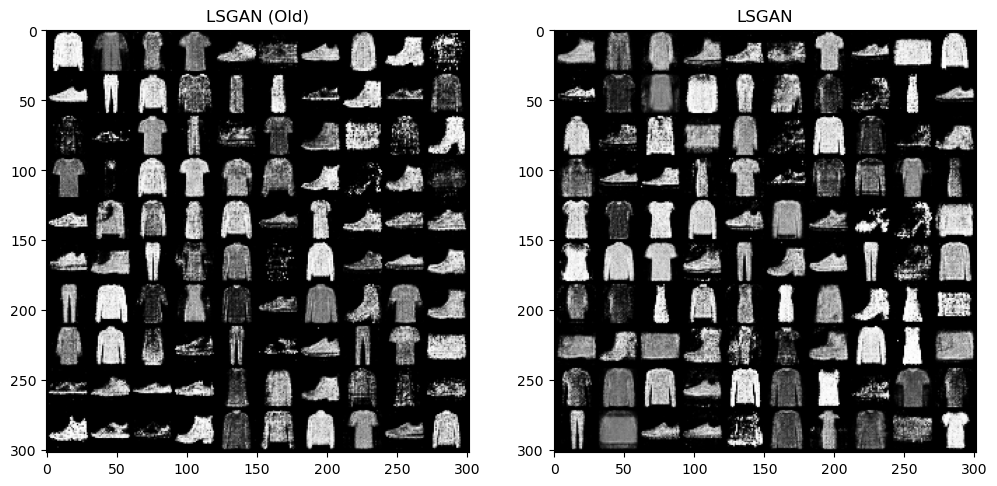

In [39]:
im1 = plt.imread('./LS_Samples/fake_images-0300.png')
im2 = plt.imread('./new_LS_Samples/fake_images-0030.png')
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(im1)
axes[1].imshow(im2)
axes[0].set_title('LSGAN (Old)')
axes[1].set_title('LSGAN')
plt.show()

#Image('./samples/fake_images-0100.png')
#Image('./LS_Samples/fake_images-0100.png')

New images seem slightly less grainy.

## Comparing GAN and LSGAN (new)

Comparing the outputs for the retrained gan and retrained lsgan

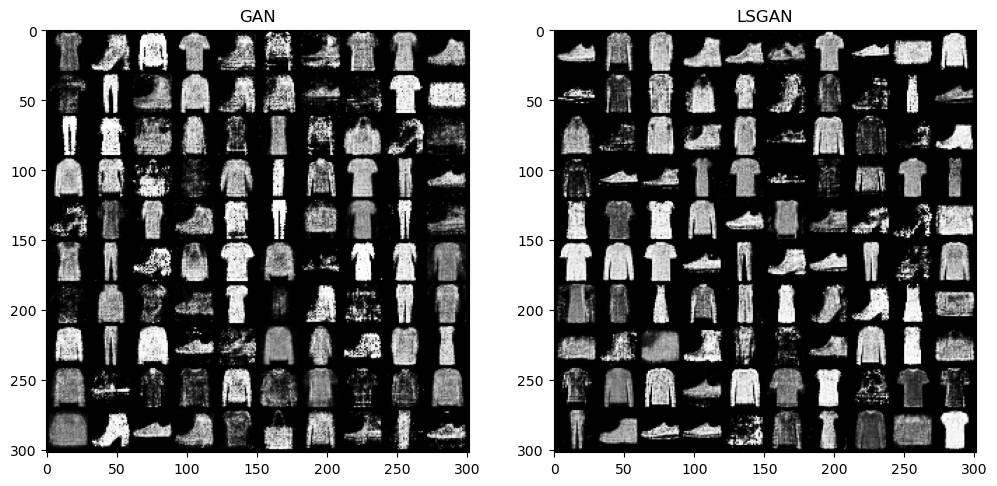

In [40]:
im1 = plt.imread('./new_samples/fake_images-0010.png')
im2 = plt.imread('./new_LS_Samples/fake_images-0010.png')
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(im1)
axes[1].imshow(im2)
axes[0].set_title('GAN')
axes[1].set_title('LSGAN')
plt.show()

#Image('./samples/fake_images-0100.png')
#Image('./LS_Samples/fake_images-0100.png')

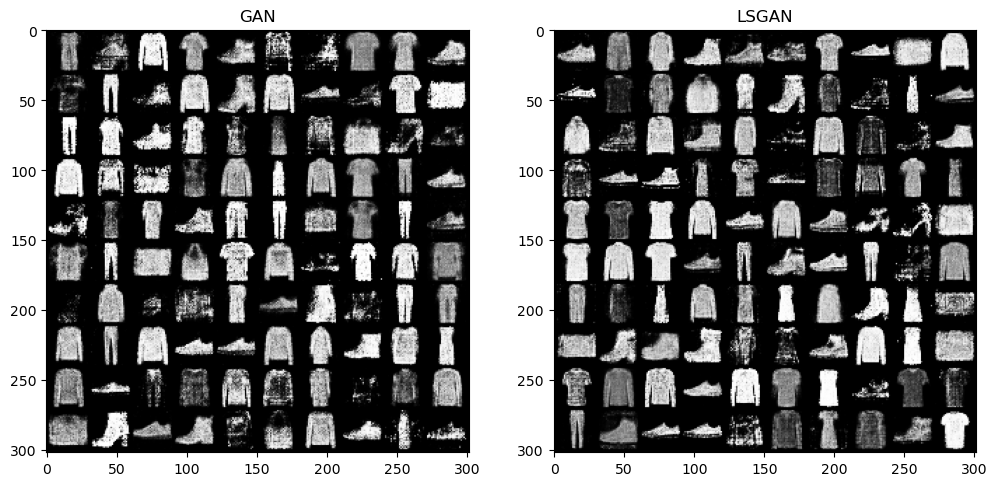

In [41]:
im1 = plt.imread('./new_samples/fake_images-0020.png')
im2 = plt.imread('./new_LS_Samples/fake_images-0020.png')
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(im1)
axes[1].imshow(im2)
axes[0].set_title('GAN')
axes[1].set_title('LSGAN')
plt.show()

#Image('./samples/fake_images-0100.png')
#Image('./LS_Samples/fake_images-0100.png')

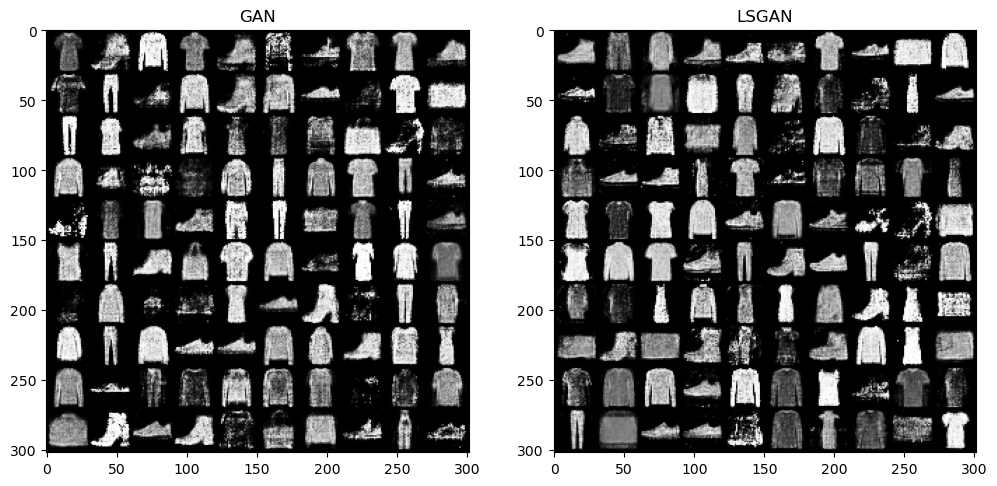

In [42]:
im1 = plt.imread('./new_samples/fake_images-0030.png')
im2 = plt.imread('./new_LS_Samples/fake_images-0030.png')
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(im1)
axes[1].imshow(im2)
axes[0].set_title('GAN')
axes[1].set_title('LSGAN')
plt.show()

#Image('./samples/fake_images-0100.png')
#Image('./LS_Samples/fake_images-0100.png')

LSGAN seems more clear.